# Logistic Regression PyTorch

MNIST Dataset Logistic Regression with forward & backward pass, loss functions, optimizers. 

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

### Preparing Data

Use `torchvision` to download train and test sets.

Note: `ToTensor()` does the following operations:
- Rescale the input data: For PIL Images, the pixel values are rescaled from the range [0, 255] to [0, 1]. For NumPy arrays, no rescaling is performed.
- Convert to Tensor: The rescaled image data is converted to a PyTorch Tensor.
- Swap axes: For PIL Images, the dimensions are swapped from (H, W, C) to (C, H, W), where H, W, and C represent Height, Width, and Channels, respectively. This is done to conform to PyTorch's expected tensor format for images.

In [17]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


Plot Image of train set.

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


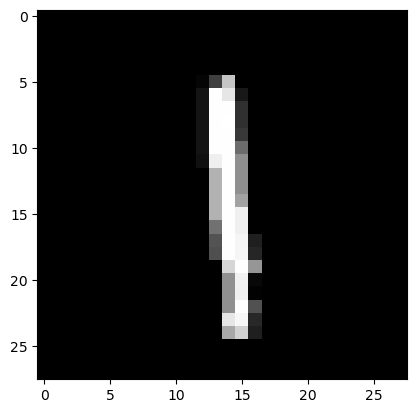

In [37]:
# Pick out the 9th (0-indexed) example from the training set
image, label = mnist_train[8]

# Plot the image
print("Default image shape: {}".format(image.shape)) # 1 in the 1st dimension means only 1 channel (greyscale)
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape)) # Remove the 1st dimension to plot
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

Use `DataLoader` for shuffling and batching, to create minibatches.

In [36]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)


for images, labels in train_loader:
    print(f"Shape of the minibatch of images: {images.shape}")
    print(f"Shape of the minibatch of labels: {labels.shape}")
    # Add any additional processing or training code here
    break  # Remove this line if you want to iterate over the entire dataset

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


### Logistic Regression Model

#### Forward Pass (Init)

Treat inputs as flat vectors as digits in MNIST dataset are small, and model is simple.

Use `view()` to convert inputs into row vectors (flattening). Replace one of the dimensions with `-1` to tell PyTorch to infer this dimension based on original dimensions and other specified dimensions.

In [38]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


To get our predicted probabilities of each digit, start with the probability of a digit being a 1 like the image above. 

Apply linear transformation by multiplying each pixel $x_i$ of the input row vector by a weight $w_{i,1}$, sum them all together, and then adding a bias $b_1$.
This is equivalent to a dot product between the class "1" weights and the input:

\begin{align}
y_1 = \sum_i x_i w_{i,1} + b_1
\end{align}

The higher the value of $y_1$, the more likely we think the input image $x$ was a 1. 

To identify all 10 digits:

\begin{align*}
y_0 =& \sum_i x_i w_{i,0} + b_0 \\
y_1 =& \sum_i x_i w_{i,1} + b_1 \\
y_2 =& \sum_i x_i w_{i,2} + b_2 \\
y_3 =& \sum_i x_i w_{i,3} + b_3 \\
y_4 =& \sum_i x_i w_{i,4} + b_4 \\
y_5 =& \sum_i x_i w_{i,5} + b_5 \\
y_6 =& \sum_i x_i w_{i,6} + b_6 \\
y_7 =& \sum_i x_i w_{i,7} + b_7 \\
y_8 =& \sum_i x_i w_{i,8} + b_8 \\
y_9 =& \sum_i x_i w_{i,9} + b_9
\end{align*}

We can express this in matrix form as:

\begin{align}
y = x W + b 
\end{align}

To take advantage of parallel computation, we commonly process multiple inputs $x$ at once, in a minibatch.
We can stack each input $x$ into a matrix $X$, giving us 

\begin{align}
Y = X W + b 
\end{align}

In our specific example, the minibatch size $m$ is $100$, the dimension of the data is $28 \times 28=784$, and the number of classes $c$ is $10$.
While $X$ and $Y$ are matrices due to the batching, conventionally, they are often given lowercase variable names, as if they were for a single example.
We will use `x` and `y` throughout.

The weight $W$ and bias $b$ make up the parameters of this model.

Next, learn the model by finding good values for every element in $W$ and $b$.

Before we begin learning, we need to initialize our parameters to some value, as a starting point.
Here, we don't really know what the best values are, so initialize $W$ randomly (using something called [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html)), and set $b$ to a vector of zeros.

In [53]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

# As both `W` and `b` are parameters we wish to learn, we set `requires_grad` to `True`. 
# This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on `W` and `b`.

Compute $y$ with these model parameters:

In [54]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

print(y[0,:])

tensor([ 0.3687, -0.3464,  0.3133, -0.2657, -0.1009,  0.0777,  0.2062, -0.4710,
        -0.5439,  0.3837], grad_fn=<SliceBackward0>)


Normalize values (logits) $y$ as probabilities using softmax (for logistic regression):

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

Notice that because the range of the exponential function is always non-negative, and since we're normalizing by the sum, the softmax achieves the desired property of producing values between 0 and 1 that sum to 1. If we look at the case with only 2 classes, we see that the softmax is the multi-class extension of the binary sigmoid function: 


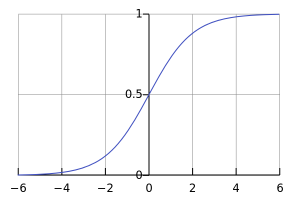


Compute softmax using PyTorch `torch.nn.functional`:

In [55]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.1421, 0.0695, 0.1345, 0.0754, 0.0889, 0.1062, 0.1208, 0.0614, 0.0571,
        0.1443], grad_fn=<SelectBackward0>)
py[0] with torch.nn.functional.softmax: tensor([0.1421, 0.0695, 0.1345, 0.0754, 0.0889, 0.1062, 0.1208, 0.0614, 0.0571,
        0.1443], grad_fn=<SelectBackward0>)


#### Cross-Entropy Loss (Loss Function)

We need to measure how the model is doing before we adjust any weights. Do this using **loss function**, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance.
This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory.
Can think of it as a way of quantifying how far apart one distribution $y'$ is from another $y$.

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}

$y$ is the set of probabilities predicted by the model ($py$ above); $y'$ is the target distribution (true label which we want the model to predict).

Cross-entropy not only captures how *correct* (max probability corresponds to the right answer) the model's answers are, it also accounts for how *confident* (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax. 

Cross-entropy captures both how correct (max probability corresponds to the right answer) the models answers are and how confident (high confidence in correct answers) they are.  

This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax. 

Here we are doing **supervised** learning, a setting in which we have the labels.
Our `DataLoader` automatically includes the corresponding labels for each of our inputs.

In [56]:
# labels from the first minibatch
print(labels.shape)

torch.Size([100])


`torch.nn.functional` already has the cross-entropy loss implemented as well.

In [57]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.348916530609131
cross entropy with torch.nn.functional.cross_entropy: 2.34891676902771


Note that PyTorch's cross-entropy loss combines the softmax operator and cross-entropy into a single operation, for numerical stability reasons.

Make sure to feed in the pre-softmax logits `y`, not the post-softmax probabilities `py`.

#### Backwards Pass (Back Propagation)

Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss.

Now we want to improve the model by changing parameters to minimize loss, via **Back Propagation**, by
taking the gradient of the loss with respect to $W$ and $b$ and take a step in the direction that reduces our loss.

First, create an optimizer.
Use standard stochastic gradient descent (SGD) as logistic regression model is simple, which makes the following update:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter, $\alpha$ is our learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [61]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1) 
# W = weight tensor
# b = bias term
# lr = learning rate

Call the `backward()` function on the cross-entropy loss to compute gradients for $W$ and $b$.

In [59]:
cross_entropy.backward()

Each of the variables that required gradients have now accumulated gradients.
For example on `b`:

In [60]:
b.grad

tensor([-0.0089,  0.0158,  0.0256,  0.0226,  0.0021, -0.0003, -0.0361, -0.0920,
         0.0366,  0.0346])

Perform update step:

In [62]:
optimizer.step()

So b has now been updated by `-0.1*b.grad` (since lr = 0.1)

In [63]:
b

tensor([ 8.9371e-04, -1.5800e-03, -2.5576e-03, -2.2605e-03, -2.0957e-04,
         3.1560e-05,  3.6072e-03,  9.1989e-03, -3.6590e-03, -3.4646e-03],
       requires_grad=True)

Training is now done on 1 minibatch, however need to repeat this process for multiple minibatches.

Note: Gradients calculated by `backward()` don't override the old values; instead, they accumulate.
Therefore, need to clear the gradient buffers before computing gradients for the next minibatch.

In [68]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0089,  0.0158,  0.0256,  0.0226,  0.0021, -0.0003, -0.0361, -0.0920,
         0.0366,  0.0346])
b.grad after zero_grad(): None


#### Model Training

To train the model, repeat for more minibatches from the training set.
Steps:
1. Draw a minibatch
2. Zero the gradients in the buffers for `W` and `b`
3. Perform the forward pass (compute prediction, calculate loss)
4. Perform the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is an epoch.
Also wrap the train_loader with `tqdm` (for progress bar)

In [69]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

#### Testing

For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. 

Then compute an accuracy by seeing how many we got correct.

(Wrap evaluation with `torch.no_grad()` because no need to compute gradients during evaluation)

In [70]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9023000001907349


Plot model learning since it is simple here:

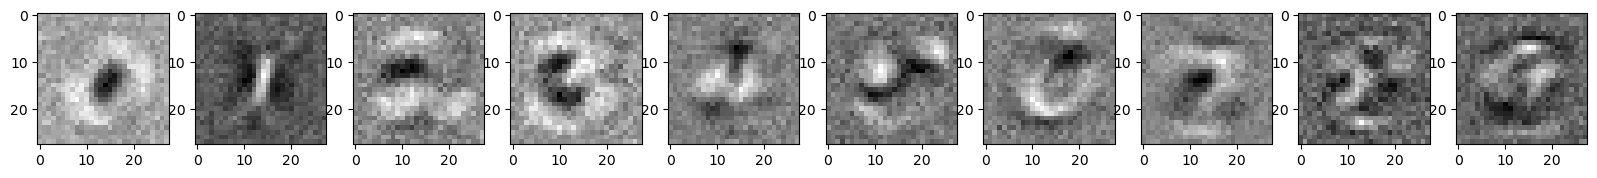

In [71]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

As we can see, the model learned a template for each digit.
Remember that our model takes a dot product between the weights of each digit and input.
Therefore, the more the input matches the template for a digit, the higher the value of the dot product for that digit will be, which makes the model more likely to predict that digit.

### High Level APIs

Important to use APIs to speed up implementations and improve model organization. Common way - `torch.nn.Module`

#### Object Oriented Refactorization

In the linear transformation $y = xW + b$, while the operation consisted of a matrix multiplication and addition, also associated with this operation was the instantiation of two parameters `W` and `b`, and these two parameters conceptually *belong* to the transform.

As such, it would make sense to bundle up the instantiation of the two parameters with the actual transformation.

We can place our entire neural network within a `Module`.
In this case, the module can track all of its associated parameters, some of which may also be associated with a submodule (e.g. `nn.Linear`), while also defining the `forward()` function, in one place.

In [76]:
import torch.nn as nn

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

In this particular example, we didn't need to chain any operations, but we'll see this come in handy as we move on to more complex models.
Additionally, the `nn.Module` that we subclassed has a few other nice features.
For example:
- The `forward()` function of a `nn.Module` will call the `forward()` function of any child `nn.Module`s.
- `print()` will print out a formatted summary of our model, recursively summarizing any child `nn.Module`s as well.
- The `parameters()` function will return a generator that returns all parameters of a `nn.Module` (including those of any children).

In [78]:
model = MNIST_Logistic_Regression()
x_rand = torch.randn(1,784)

y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[-0.0139,  0.0314, -0.0267,  ...,  0.0180,  0.0041,  0.0131],
        [ 0.0039, -0.0321, -0.0139,  ..., -0.0155, -0.0341,  0.0009],
        [-0.0093,  0.0309, -0.0115,  ..., -0.0068, -0.0028,  0.0022],
        ...,
        [-0.0098,  0.0029,  0.0221,  ..., -0.0220, -0.0024, -0.0206],
        [-0.0110, -0.0148, -0.0326,  ...,  0.0032,  0.0222, -0.0104],
        [ 0.0140, -0.0210,  0.0246,  ..., -0.0115,  0.0342,  0.0122]],
       requires_grad=True), Parameter containing:
tensor([-0.0322,  0.0013, -0.0100, -0.0171, -0.0155,  0.0053, -0.0251,  0.0022,
        -0.0160,  0.0161], requires_grad=True)]

Output shape: 
torch.Size([1, 10])


### Full Code (Default)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

### Full Code (with `nn.Module`)

In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9031000137329102
